[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/oscar09/ml_kidney_stones/blob/main/patches_colab_base.ipynb)



### Steps to perform before running this notebook:
- You must have access to shared folder: **Proyecto_CalculosRenales**.
- You need to add a shorcut for this folder (right click -> Add shortcut to drive).

Imports required libraries and define global variables.

In [ ]:
# importing all the required libraries
import numpy as np
import warnings
import copy
import random
import string
import os
import shutil
warnings.filterwarnings('ignore')
import numpy as np
from tqdm.notebook import tqdm
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp, resize
from sklearn.model_selection import train_test_split
from PIL import Image

import torch
import seaborn as sns
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from skimage.util import random_noise
from skimage.util import img_as_ubyte
from skimage.filters import gaussian
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction import image
#% matplotlib inline

!pip install tensorboard --quiet
! pip install pytorch-lightning --quiet
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.metrics.functional import accuracy
from pytorch_lightning.callbacks import EarlyStopping 

#optional
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Initialization

Some classes are used in different notebooks. To keep all the code in a single place, the below code will clone the "ml_kindey_stones" repository and import the classes we need for the current notebook.

In [ ]:
!rm -r ml_kidney_stones
GIT_PATH = "https://b5d855b5170d85046de2b73eb566937c894aec67@github.com/oscar09/ml_kidney_stones.git"
!cd /content/ && git clone "{GIT_PATH}"

Cloning into 'ml_kidney_stones'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 43 (delta 14), reused 10 (delta 2), pack-reused 0
Unpacking objects: 100% (43/43), done.


In [ ]:
import ml_kidney_stones.helpers.KidneyImagesLoader as kl
import ml_kidney_stones.helpers.PlotHelper as kplt

Initializes the variables that are used in this notebook. The mean and std used for normalization are the values given by ImageNET. If we need to run tests with different values, we just need to update the below code and run the whole notebook or the cell we are interested in.

The image size is also set to 256x256, which is the dimension used by AlexNet. The dataset will be resized to this dimension. Transformations are also defined in here and the following transformations are being applied:

Training set:
- RandomHorizontalFlip(p=0.5),
- RandomVerticalFlip(p=0.5),
- Pad(50, fill=0, padding_mode="symmetric"),
- RandomPerspective(distortion_scale=0.4, p=0.5),
- RandomAffine(degrees=(-90, 90), translate=(0, 0.2), scale=[0.5, 1]),
- RandomRotation(degrees=(-180, 180))

This transformations are applied randomly and only 1 on every iteration. For the test dataset no transformations are being applied.

Early stopping (with a patience of 30) is also being used in every test. But at least MIN_EXEC_EPOCHS epochs should be executed before early stopping is applied.

In [ ]:
LOGS_PATH = "tb_logs/" #"/content/drive/My Drive/colab_logs/"
TOTAL_GPUS = 0
if torch.cuda.is_available():
  TOTAL_GPUS = 1


#imagenet values
#@TODO - I need to calculate the  mean and std for our images.
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
#mean = np.array([0.5, 0.5, 0.5])
#std = np.array([0.5, 0.5, 0.5])

IMG_SIZE = 256 # Expected size for AlexNet.

# WITH augmentation
image_transforms = {
    "train": transforms.Compose([
      transforms.RandomChoice([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Pad(50, fill=0, padding_mode="symmetric"),
        transforms.RandomPerspective(distortion_scale=0.4, p=0.5),
        transforms.RandomAffine(degrees=(-90, 90), translate=(0, 0.2), scale=[0.5, 1]),
        #transforms.ColorJitter(brightness=0.35, contrast=0.4, saturation=0.5, hue=0),
        transforms.RandomRotation(degrees=(-180, 180)),                     
      ]),
      transforms.Resize((IMG_SIZE, IMG_SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)                           
    ]),
    "test": transforms.Compose([
      transforms.Resize((IMG_SIZE, IMG_SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)   
    ])
}

# WITHOUT augmentation
image_transforms_no_aug = {
    "train": transforms.Compose([
      transforms.Resize((IMG_SIZE, IMG_SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)                           
    ]),
    "test": transforms.Compose([
      transforms.Resize((IMG_SIZE, IMG_SIZE)),
      transforms.ToTensor(),
      transforms.Normalize(mean, std)   
    ])
}

# Early stopping
stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.0,
    patience=30,
    verbose=True,
    mode='min'
)

# min epochs to run
MIN_EXEC_EPOCHS = 140
# max epochs to run
MAX_EXEC_EPOCHS = 500

## Aditional code to store the tensorobard logs in google drive.
def synch_logs(drive_path):
  !rsync -av --progress "$LOGS_PATH" "$drive_path"

def clear_logs():
  !rm -r "$LOGS_PATH"

def copy_logs(drive_path):
  !rsync -av --progress "$drive_path" "$LOGS_PATH"

# Define a CNN Architecture.

AlexNET is used for the next tests.


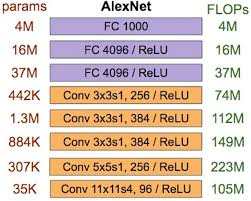

In [ ]:
class BaseModel(pl.LightningModule):
"""
Base model where all the methods required by pytorch lightning are defined.
"""
  def __init__(self, learning_rate=0.05, index_to_label = None):
    super(BaseModel, self).__init__()
    self.learning_rate = learning_rate
    self.index_to_label = index_to_label

  def training_step(self, batch, batch_idx):
    x, y = batch
    y_val_pred = self(x).squeeze()
    loss = F.cross_entropy(y_val_pred, y)
    acc = self.multi_acc(y_val_pred, y)
    return {
        'loss': loss,
        'accuracy': acc
        }

  def on_fit_start(self):
    self.accuracy_history = { "train": [], "val": [] }
    self.loss_history = { "train": [], "val": [] }

  def on_fit_end(self):
    if len(self.accuracy_history["train"]) < len(self.accuracy_history["val"]):
      self.accuracy_history["val"] = self.accuracy_history["val"][:len(self.accuracy_history["train"])]

    if len(self.loss_history["train"]) < len(self.loss_history["val"]):
      self.loss_history["val"] = self.loss_history["val"][:len(self.loss_history["train"])]

  def test_step(self, batch, batch_idx):
    # Here we just reuse the validation_step for testing
    #return self.validation_step(batch, batch_idx)
    x, y = batch
    y_test_pred = self(x)
    y_test_pred = torch.log_softmax(y_test_pred[0], dim=0)
    pred, pred_index = torch.max(y_test_pred, dim=0)
    return { "real": y, "pred": pred_index, "correct": int(y == pred_index) }

  def training_epoch_end(self, outputs):
    avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
    acc = sum([x["accuracy"] for  x in outputs])
    avg_acc = acc/len(outputs)
    self.accuracy_history["train"].append(avg_acc.item())
    self.loss_history["train"].append(avg_loss.item())
    #logs = {'Train Loss': avg_loss, 'Train Accuracy': acc/len(outputs), 'step': self.current_epoch}
    self.logger.experiment.add_scalars("Loss", {"train_loss": avg_loss}, global_step=self.current_epoch)
    self.logger.experiment.add_scalars("Accuracy", {"train_acc": avg_acc}, global_step=self.current_epoch)
    self.logger.experiment.flush()
    #return {
    #    'loss': avg_loss,
    #    #'log': logs
    #    }

  def validation_epoch_end(self, outputs):
    avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    acc = sum([x["accuracy"] for  x in outputs])
    avg_acc = acc/len(outputs)
    self.accuracy_history["val"].append(avg_acc.item())
    self.loss_history["val"].append(avg_loss.item())
    self.logger.experiment.add_scalars("Loss", {"val_loss": avg_loss}, global_step=self.current_epoch)
    self.logger.experiment.add_scalars("Accuracy", {"val_acc": avg_acc}, global_step=self.current_epoch)
    results = {'val_loss': avg_loss}
    self.logger.experiment.flush()
    return results

  def test_epoch_end(self, outputs):
    real = [x["real"].item() for  x in outputs]
    pred = [x["pred"].item() for  x in outputs]
    correct = sum([x["correct"] for  x in outputs])

    labels = None
    if self.index_to_label:
      labels = []
      for k in self.index_to_label:
        labels.append(self.index_to_label[k])

    print(classification_report(real, pred, target_names=labels))
    result = pl.EvalResult()
    result.log('accuracy', round(correct/len(outputs), 2))
    return result

  def validation_step(self, batch, batch_idx):
    x, y = batch

    y_val_pred = self(x).squeeze()
    y_val_pred = torch.unsqueeze(y_val_pred, 0)

    loss = F.cross_entropy(y_val_pred, y)

    acc = self.multi_acc(y_val_pred, y)
    return {
        'val_loss': loss,
        'accuracy': acc
        }

  """
  Returns the model accuracy comparing y predicted vs y expected.
  """
  def multi_acc(self, y_pred, y_test):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_softmax, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = acc * 100
    return acc

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    return optimizer

  def get_accuracy_history(self):
    return self.accuracy_history

  def get_loss_history(self):
    return self.loss_history

In [ ]:
class AlexNet(BaseModel):
"""
AlexNet CNN
"""
  def __init__(self, num_classes=1000, data_dir='./', *args, **kwargs):
    super(AlexNet, self).__init__(*args, **kwargs)

    self.data_dir = data_dir
    self.num_classes = num_classes
    
    self.features = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(64, 192, kernel_size=5, padding=2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
        nn.Conv2d(192, 384, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(384, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=3, stride=2),
    )
    self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
    self.classifier = nn.Sequential(
        nn.Dropout(),
        nn.Linear(256 * 6 * 6, 4096),
        nn.ReLU(inplace=True),
        nn.Dropout(),
        nn.Linear(4096, 4096),
        nn.ReLU(inplace=True),
        nn.Linear(4096, self.num_classes),
    )

  def forward(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = torch.flatten(x, 1)
    x = self.classifier(x)
    return x

# Testing the model: *Images with patches and all classes*

The below cells test the AlexNET model with our patches dataset and classifies the images in 6 classes (weddellite_surfaces, weddellite_sections, acide_urique_surface, acide_urique_section, whewellite_surface, whewellite_section).

At the same time, the test is split in 2 subtests: using training images with transformations (listed previously) and without transformations. In both scenarios, the below hyper parameters are used:
- **Percentage of the training set that is used for validation:** 20%.
- **Batch size for the training set:** 32,
- **Learning rate:** .0001.
- **Early stopping**.

For every test logs are being generated and can be rendered at the end of this notebook under the section "Tensorboard logs".


## Images with augmentation

In [ ]:
dl_six_classes = kl.KidneyImagesLoader(zip_path="/content/drive/My Drive/Proyecto_CalculosRenales/Imagenes/ML/patches/patches_six_classes.zip",
                          val_percentage=0.2,
                          train_batch_size = 32,
                          train_transformations=image_transforms["train"],
                          test_transformations=image_transforms["test"])

model = AlexNet(learning_rate=0.0001, num_classes=6)

logger_patched_six = TensorBoardLogger(LOGS_PATH, name='alexnet_patched_six', version=".")
trainer_patched_six = pl.Trainer(gpus=TOTAL_GPUS,
                     max_epochs=MAX_EXEC_EPOCHS,
                     min_epochs=MIN_EXEC_EPOCHS,
                     logger=logger_patched_six,
                     early_stop_callback=stopping,
                     progress_bar_refresh_rate=1,
                     checkpoint_callback=False, # disable checkpoint logs
                     #auto_lr_find="learning_rate"
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### Training Phase

Training phase is executed and the accuracy and loss history values are plot for comparison.

In [ ]:
trainer_patched_six.fit(model, dl_six_classes)


  | Name       | Type              | Params
-------------------------------------------------
0 | features   | Sequential        | 2 M   
1 | avgpool    | AdaptiveAvgPool2d | 0     
2 | classifier | Sequential        | 54 M  


Epoch 00265: early stopping triggered.


1

In [ ]:
acc_history = model.get_accuracy_history()
loss_history = model.get_loss_history()

265

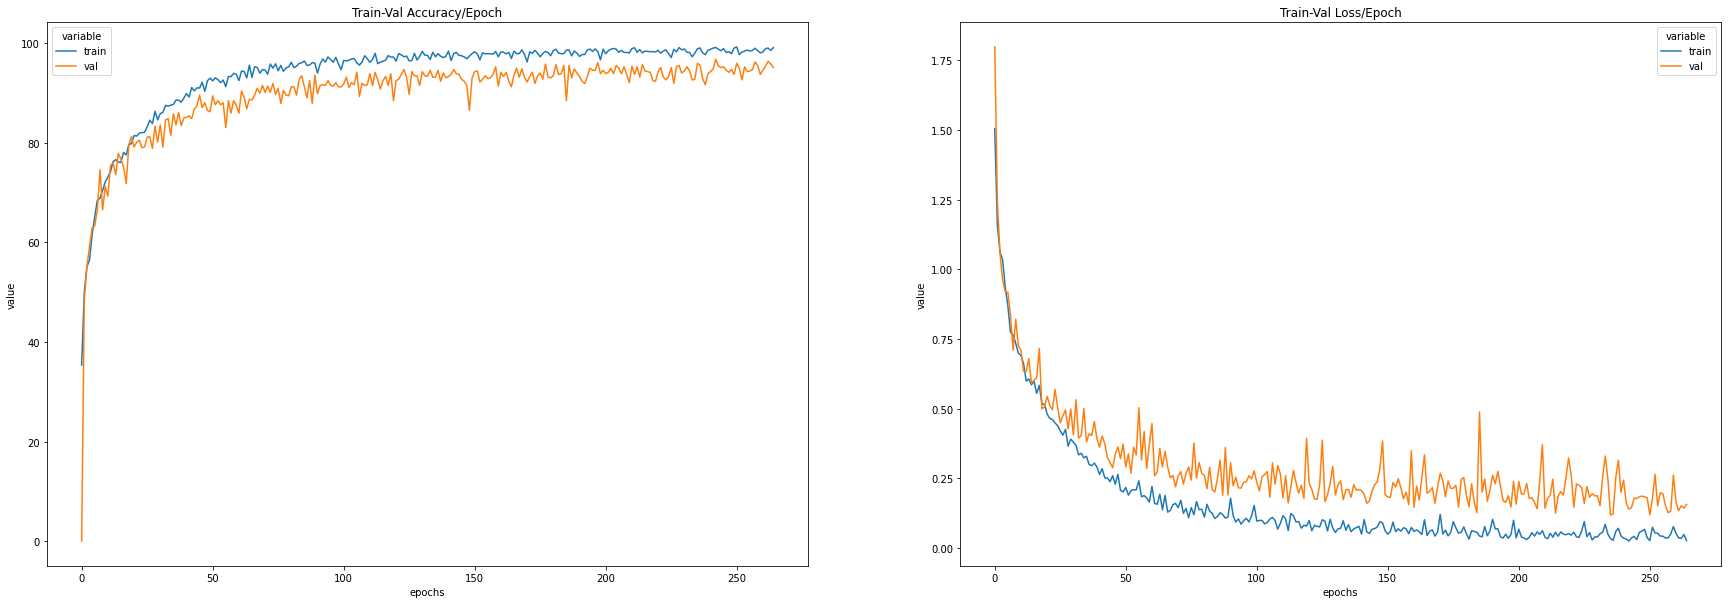

In [ ]:
plotter = kplt.PlotHelper()
plotter.show_training_results(acc_history, loss_history)

### Test Phase

Displays the classification report based on the trained model.

In [ ]:
trainer_patched_six.test(model=model, datamodule=dl_six_classes)

              precision    recall  f1-score   support

           0       0.96      0.91      0.94       150
           1       0.96      0.99      0.97       150
           2       0.92      0.92      0.92       150
           3       0.94      0.94      0.94       150
           4       0.98      1.00      0.99       150
           5       0.99      0.99      0.99       150

    accuracy                           0.96       900
   macro avg       0.96      0.96      0.96       900
weighted avg       0.96      0.96      0.96       900

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.96}
--------------------------------------------------------------------------------



[{'accuracy': 0.96}]

## Images without augmentation

In [ ]:
dl_six_classes_na = kl.KidneyImagesLoader(zip_path="/content/drive/My Drive/Proyecto_CalculosRenales/Imagenes/ML/patches/patches_six_classes.zip",
                          val_percentage=0.2,
                          train_batch_size = 32,
                          train_transformations=image_transforms_no_aug["train"],
                          test_transformations=image_transforms_no_aug["test"])

model_na = AlexNet(learning_rate=0.0001, num_classes=6)

logger_patched_six_na = TensorBoardLogger(LOGS_PATH, name='alexnet_patched_six_noaug', version=".")
trainer_patched_six_na = pl.Trainer(gpus=TOTAL_GPUS,
                     max_epochs=MAX_EXEC_EPOCHS,
                     min_epochs=MIN_EXEC_EPOCHS,
                     logger=logger_patched_six_na,
                     early_stop_callback=stopping,
                     progress_bar_refresh_rate=1,
                     checkpoint_callback=False, # disable checkpoint logs
                     #auto_lr_find="learning_rate"
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### Training Phase

Training phase is executed and accuracy and loss history values are plot for comparison.

In [ ]:
trainer_patched_six_na.fit(model_na, dl_six_classes_na)


  | Name       | Type              | Params
-------------------------------------------------
0 | features   | Sequential        | 2 M   
1 | avgpool    | AdaptiveAvgPool2d | 0     
2 | classifier | Sequential        | 54 M  


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Epoch 00140: early stopping triggered.


1

In [ ]:
acc_history_na = model_na.get_accuracy_history()
loss_history_na = model_na.get_loss_history()

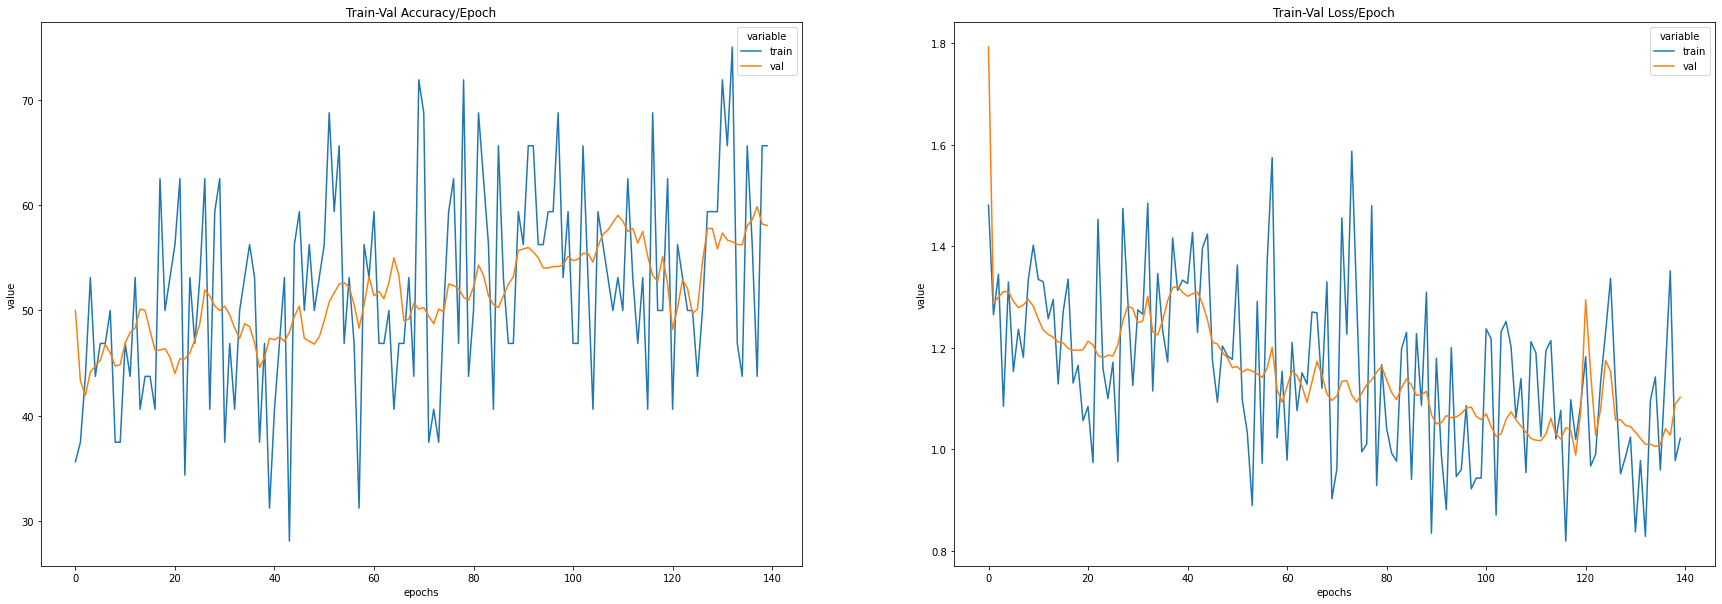

In [ ]:
plotter.show_training_results(acc_history_na, loss_history_na)

### Test Phase

Displays the classification report based on the trained model.

In [ ]:
trainer_patched_six_na.test(model=model_na, datamodule=dl_six_classes_na)

              precision    recall  f1-score   support

           0       0.71      0.10      0.18       150
           1       0.54      0.75      0.63       150
           2       0.62      0.52      0.57       150
           3       0.43      0.81      0.56       150
           4       0.94      0.79      0.86       150
           5       0.89      0.81      0.85       150

    accuracy                           0.63       900
   macro avg       0.69      0.63      0.61       900
weighted avg       0.69      0.63      0.61       900

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.63}
--------------------------------------------------------------------------------



[{'accuracy': 0.63}]

# Testing the model: *Images with patches and three classes*

The below cells test the AlexNET model with our patches dataset and classifies the images in 3 classes (weddellite, acide_urique, whewellite). "Surface" and "Section" datasets are merged into a single class.

At the same time, the test is split in 2 subtests: using training images with transformations (listed previously) and without transformations. In both scenarios, the below hyper parameters are used:
- **Percentage of the training set that is used for validation:** 20%.
- **Batch size for the training set:** 32,
- **Learning rate:** .0001.
- **Early stopping**.

For every test logs are being generated and can be rendered at the end of this notebook under the section "Tensorboard logs".

## Images with augmentation

In [ ]:
dl_three_classes = kl.KidneyImagesLoader(zip_path="/content/drive/My Drive/Proyecto_CalculosRenales/Imagenes/ML/patches/patches_three_classes.zip",
                          val_percentage=0.2,
                          train_batch_size = 32,
                          train_transformations=image_transforms["train"],
                          test_transformations=image_transforms["test"])

model_three = AlexNet(learning_rate=0.0001, num_classes=3)

logger_patched_three = TensorBoardLogger(LOGS_PATH, name='alexnet_patched_three', version=".")
trainer_patched_three = pl.Trainer(gpus=TOTAL_GPUS,
                     max_epochs=MAX_EXEC_EPOCHS,
                     min_epochs=MIN_EXEC_EPOCHS,
                     logger=logger_patched_three,
                     early_stop_callback=stopping,
                     progress_bar_refresh_rate=1,
                     checkpoint_callback=False, # disable checkpoint logs
                     #auto_lr_find="learning_rate"
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### Training Phase

Training phase is executed and the accuracy and loss history values are plot for comparison.

In [ ]:
trainer_patched_three.fit(model_three, dl_three_classes)


  | Name       | Type              | Params
-------------------------------------------------
0 | features   | Sequential        | 2 M   
1 | avgpool    | AdaptiveAvgPool2d | 0     
2 | classifier | Sequential        | 54 M  


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Epoch 00140: early stopping triggered.


1

In [ ]:
acc_history_three = model_three.get_accuracy_history()
loss_history_three = model_three.get_loss_history()

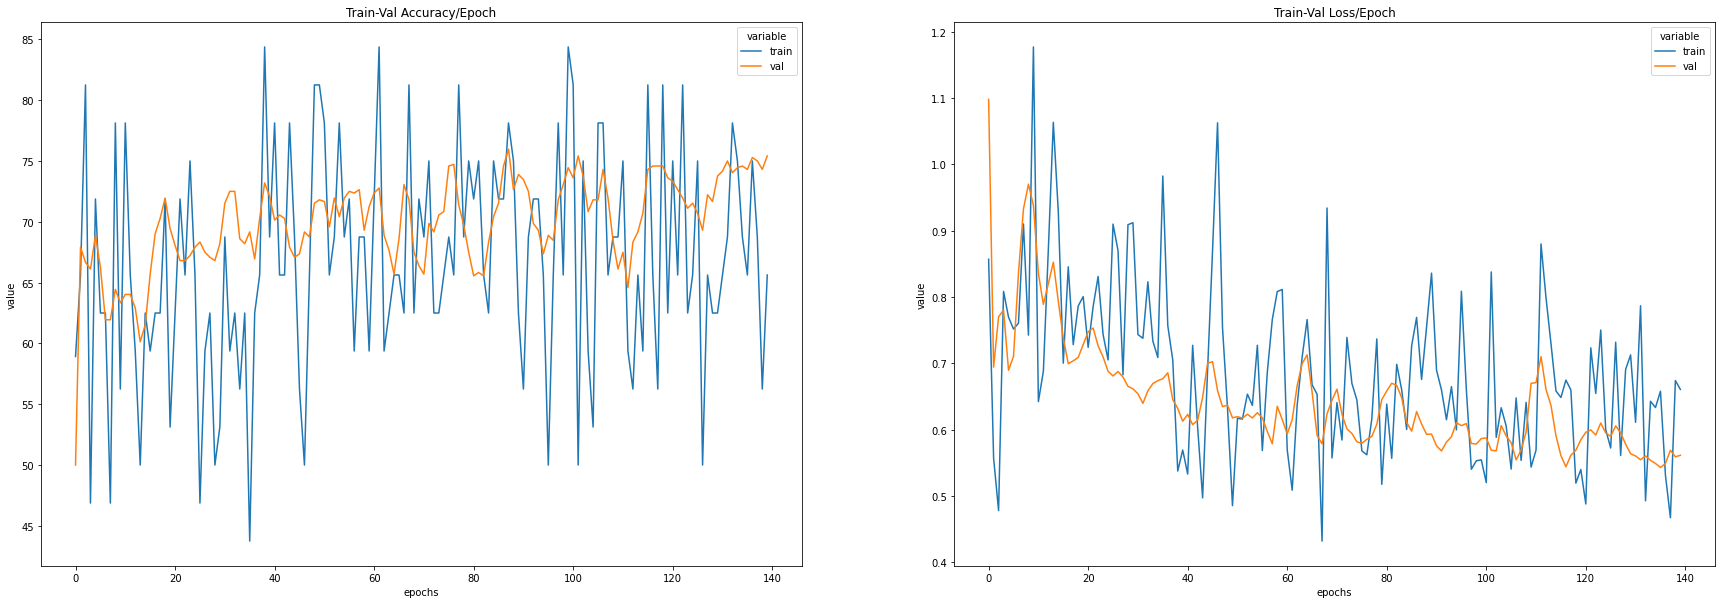

In [ ]:
plotter.show_training_results(acc_history_three, loss_history_three)

### Test Phase

Displays the classification report based on the trained model.

In [ ]:
trainer_patched_three.test(model=model_three, datamodule=dl_three_classes)

              precision    recall  f1-score   support

           0       0.68      0.61      0.64       300
           1       0.60      0.69      0.64       300
           2       0.88      0.84      0.86       300

    accuracy                           0.71       900
   macro avg       0.72      0.71      0.71       900
weighted avg       0.72      0.71      0.71       900

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.71}
--------------------------------------------------------------------------------



[{'accuracy': 0.71}]

## Images without augmentation

In [ ]:
dl_three_classes_na = kl.KidneyImagesLoader(zip_path="/content/drive/My Drive/Proyecto_CalculosRenales/Imagenes/ML/patches/patches_three_classes.zip",
                          val_percentage=0.2,
                          train_batch_size = 32,
                          train_transformations=image_transforms_no_aug["train"],
                          test_transformations=image_transforms_no_aug["test"])

model_three_na = AlexNet(learning_rate=0.0001, num_classes=3)

logger_patched_three_na = TensorBoardLogger(LOGS_PATH, name='alexnet_patched_three_na', version=".")
trainer_patched_three_na = pl.Trainer(gpus=TOTAL_GPUS,
                     max_epochs=MAX_EXEC_EPOCHS,
                     min_epochs=MIN_EXEC_EPOCHS,
                     logger=logger_patched_three_na,
                     early_stop_callback=stopping,
                     progress_bar_refresh_rate=1,
                     checkpoint_callback=False, # disable checkpoint logs
                     #auto_lr_find="learning_rate"
                     )

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


### Training Phase

Training phase is executed and the accuracy and loss history values are plot for comparison.

In [ ]:
trainer_patched_three_na.fit(model_three_na, dl_three_classes_na)


  | Name       | Type              | Params
-------------------------------------------------
0 | features   | Sequential        | 2 M   
1 | avgpool    | AdaptiveAvgPool2d | 0     
2 | classifier | Sequential        | 54 M  


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Trainer was signaled to stop but required minimum epochs (140) or minimum steps (None) has not been met. Training will continue...


Epoch 00140: early stopping triggered.


1

In [ ]:
acc_history_three_na = model_three_na.get_accuracy_history()
loss_history_three_na = model_three_na.get_loss_history()

In [ ]:
plotter.show_training_results(acc_history_three_na, loss_history_three_na)

### Test Phase

Displays the classification report based on the trained model.

In [ ]:
trainer_patched_three_na.test(model=model_three_na, datamodule=dl_three_classes_na)

              precision    recall  f1-score   support

           0       0.74      0.58      0.65       300
           1       0.62      0.72      0.67       300
           2       0.86      0.90      0.88       300

    accuracy                           0.74       900
   macro avg       0.74      0.74      0.73       900
weighted avg       0.74      0.74      0.73       900

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.74}
--------------------------------------------------------------------------------



[{'accuracy': 0.74}]

#Tensorboard Logs

Logs captured during the tests are stored in "tb_logs" and they can be analyzed using tensorboard.

In [ ]:
#uncomment this line to pull the latest logs from google drive.
#copy_logs("/content/drive/My Drive/Proyecto_CalculosRenales/ML/logs/")

In [ ]:
# Start tensorboard.
%load_ext tensorboard
%tensorboard --logdir "$LOGS_PATH/"